epoch [1/10], loss: 0.0754
epoch [2/10], loss: 0.0461
epoch [3/10], loss: 0.0380
epoch [4/10], loss: 0.0418
epoch [5/10], loss: 0.0262
epoch [6/10], loss: 0.0172
epoch [7/10], loss: 0.0111
epoch [8/10], loss: 0.0133
epoch [9/10], loss: 0.0122
epoch [10/10], loss: 0.0300


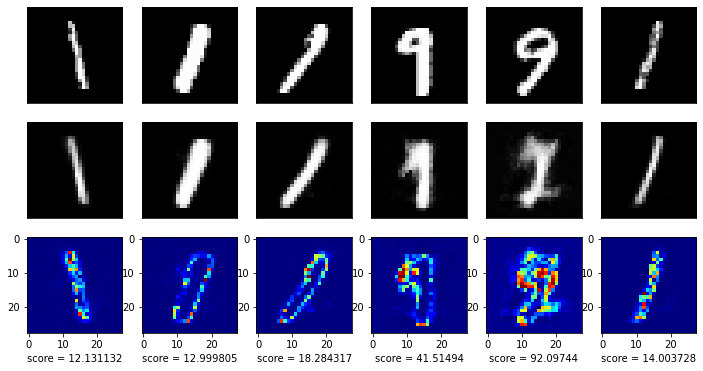

In [2]:
import os
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision.datasets import MNIST
import pylab
import matplotlib.pyplot as plt

mount_dir = './drive/MyDrive/Colab Notebooks/anomaly-detection-using-autoencoder-PyTorch-master'

class Mnisttox(Dataset):
    def __init__(self, datasets ,labels:list):
        self.dataset = [datasets[i][0] for i in range(len(datasets))
                        if datasets[i][1] in labels ]
        self.labels = labels
        self.len_oneclass = int(len(self.dataset)/10)

    def __len__(self):
        return int(len(self.dataset))

    def __getitem__(self, index):
        img = self.dataset[index]
        return img,[]

class Autoencoder(nn.Module):
    def __init__(self,z_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, z_dim))

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        xhat = self.decoder(z)
        return xhat

z_dim = 64
batch_size = 16
num_epochs = 10
learning_rate = 3.0e-4
n = 6 #number of test sample
cuda = True
model = Autoencoder(z_dim)
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-5)

if cuda:
    model.cuda()

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))  # [0,1] => [-1,1]
])
train_dataset = MNIST('./data', download=True,train=True, transform=img_transform)
train_1 = Mnisttox(train_dataset,[1])
train_loader = DataLoader(train_1, batch_size=batch_size, shuffle=True)
losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    i = 0
    for img,_ in train_loader:
        # print("now")

        x = img.view(img.size(0), -1)

        if cuda:
            x = Variable(x).cuda()
        else:
            x = Variable(x)

        xhat = model(x)

        # 出力画像（再構成画像）と入力画像の間でlossを計算
        loss = mse_loss(xhat, x)
        losses[epoch] = losses[epoch] * (i / (i + 1.)) + loss * (1. / (i + 1.))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1

    plt.figure()
    pylab.xlim(0, num_epochs)
    plt.plot(range(0, num_epochs), losses, label='loss')
    plt.legend()
    plt.savefig(os.path.join(mount_dir+"/save/", 'loss.pdf'))
    plt.close()

    print('epoch [{}/{}], loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss))

test_dataset = MNIST('./data', train=False,download=True, transform=img_transform)
test_1_9 = Mnisttox(test_dataset,[1,9])
test_loader = DataLoader(test_1_9, batch_size=len(test_dataset), shuffle=True)

for img,_ in test_loader:
    x = img.view(img.size(0), -1)

    if cuda:
        x = Variable(x).cuda()
    else:
        x = Variable(x)

    xhat = model(x)
    x = x.cpu().detach().numpy()
    xhat = xhat.cpu().detach().numpy()
    x = x/2 + 0.5
    xhat = xhat/2 + 0.5

# サンプル画像表示
plt.figure(figsize=(12, 6))
for i in range(n):
    # テスト画像を表示
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 出力画像を表示
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(xhat[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 入出力の差分画像を計算
    diff_img = np.abs(x[i] - xhat[i])

    # 入出力の差分数値を計算
    diff = np.sum(diff_img)

    # 差分画像と差分数値の表示
    ax = plt.subplot(3, n, i + 1 + n * 2)
    plt.imshow(diff_img.reshape(28, 28),cmap="jet")
    #plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    ax.set_xlabel('score = ' + str(diff))

plt.savefig(mount_dir+"/save/result.png")
plt.show()
plt.close()

